In [4]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn

In [5]:
import t2ebm

In [6]:
import textwrap

In [7]:
# Close any open plots
# plt.close('all')

##  Section 1: What is Energy?

In [ ]:
# Simple energy function example for a 1D Gaussian (µ=0, σ=1)
def gaussian_energy(x):
    return (x**2) / 2 + 0.5 * np.log(2*np.pi)  # Adding normalization constants

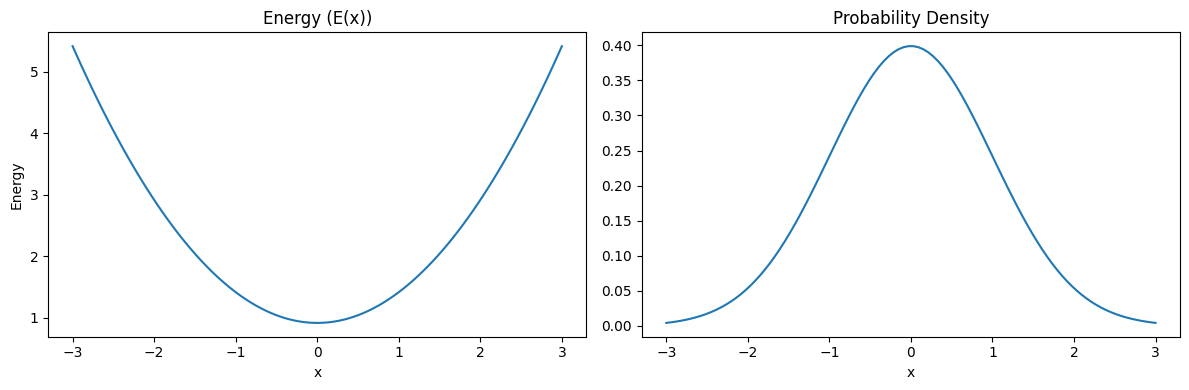

In [ ]:
# Plot energy vs probability (normal dist is prob ~ exp(-energy))
x = np.linspace(-3, 3, 100)
energy = gaussian_energy(x)
probability = np.exp(-energy)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x, energy)
plt.title("Energy (E(x))")
plt.xlabel("x")
plt.ylabel("Energy")

plt.subplot(1, 2, 2)
plt.plot(x, probability)
plt.title("Probability Density")
plt.xlabel("x")
plt.tight_layout()
plt.show()

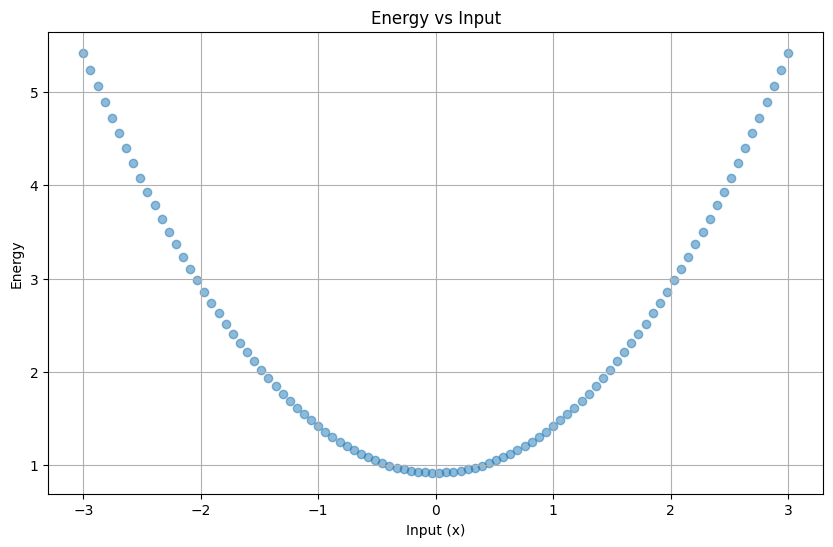

In [ ]:
#EBM ENERGY
from interpret.glassbox import ExplainableBoostingRegressor

# Assuming 'x' is your input data
X = x.reshape(-1, 1)  # Reshape to 2D array
y = energy  # Your target variable

plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.5)
plt.title("Energy vs Input")
plt.xlabel("Input (x)")
plt.ylabel("Energy")
plt.grid(True)
plt.show()


In [ ]:
# Create and fit the EBM model
ebm_model = ExplainableBoostingRegressor()
ebm_model.fit(X, y)

# Now use the fitted model with describe_graph
description_energy = t2ebm.describe_graph('gpt-4o-mini', ebm_model, 0)

INFO: The graph of feature feature_0000 was simplified by 3.5%.


In [ ]:
wrapped_description = '\n'.join(textwrap.wrap(description_energy, width=80))
formatted_description = f"\033[3m\033[94m{wrapped_description}\033[0m"

print("\nDescription of Energy using T2EBM:")
print(formatted_description)


Description of Energy using T2EBM:
The graph of "feature_0000" reveals a non-linear relationship characterized by a
significant decline in mean predictions from approximately 2.87 at -3.0 to
nearly -0.69 around -1.5. A particularly surprising aspect is the sharp drop in
mean values between the intervals (-1.818, -1.696) and (-1.696, -1.575),
suggesting a potential threshold effect. Following this low point, the
predictions rapidly increase as the feature value approaches zero, reaching
positive values beyond -1.5. The means consistently rise to approximately 2.8 as
the feature value approaches 3.0, defying expectations for potential saturation
or diminishing returns at higher values. This behavior may indicate underlying
mechanisms and interactions that significantly influence predicted outcomes. The
confidence intervals surrounding the means indicate a stable prediction across
the observed ranges, reinforcing the reliability of these surprising trends.
Overall, the graph illustrates 

## Section 2: Visualizing Energy Landscapes

In [ ]:
# Simple EnergyModel class
class EnergyModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, 8)
        self.layer2 = nn.Linear(8, 1)
    
    def forward(self, x):
        x = torch.tanh(self.layer1(x))
        return self.layer2(x)

model = EnergyModel(2)  # 2D input

In [ ]:
# Create grid of input values
x_range = np.linspace(-2, 2, 100)
y_range = np.linspace(-2, 2, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
points = np.stack([x_grid.ravel(), y_grid.ravel()], axis=1).astype(np.float32)

In [ ]:
# Compute energy values
tensor_points = torch.tensor(points)
energies = model(tensor_points).detach().numpy()

# Reshape energy values for plotting
energy_grid = energies.reshape(x_grid.shape)

Text(0.5, 0, 'Energy')

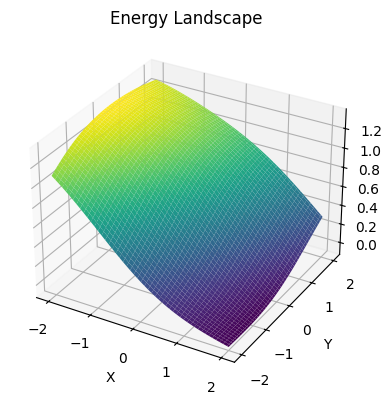

In [ ]:
# Plot energy landscape
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(x_grid, y_grid, energy_grid, cmap='viridis', edgecolor='none')
ax.set_title('Energy Landscape')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Energy')


In [ ]:
description_ai=t2ebm.describe_graph('gpt-4o-mini', ebm, 0)
# Wrap and format the description
wrapped_description = '\n'.join(wrap(description_ai, width=80))
formatted_description = f"\033[3m\033[94m{wrapped_description}\033[0m"

print("\nDescription of Global Effects of Home Planet using EBM:")
print(formatted_description)

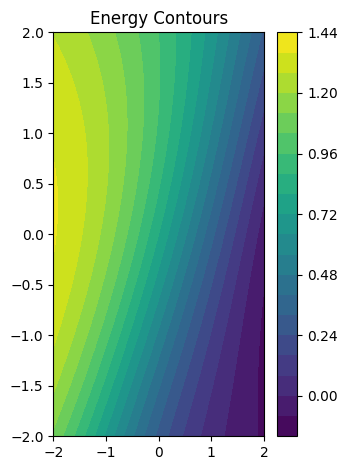

In [ ]:
# Contour plot (alternative view)
plt.subplot(1, 2, 2)
cont = plt.contourf(x_grid, y_grid, energy_grid, levels=20, cmap='viridis')
plt.colorbar(cont)
plt.title('Energy Contours')
plt.tight_layout()
plt.show()

Original layer1 weights (hidden):
 tensor([[ 0.5688, -0.3558],
        [-0.4749,  0.3940]])


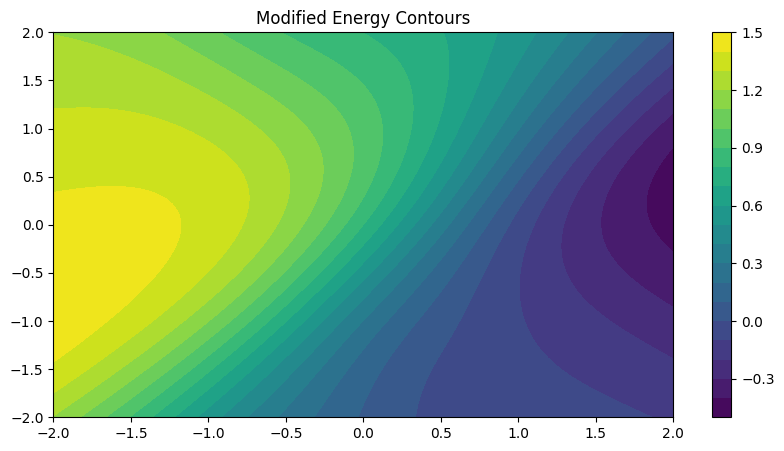

In [ ]:
# Show effect of parameter changes
print("Original layer1 weights (hidden):\n", model.layer1.weight.data[:2])

# Modify parameters and replot
model.layer1.weight.data *= 2  # Double weights to alter landscape
modified_energies = model(tensor_points).detach().numpy()
modified_energy_grid = modified_energies.reshape(x_grid.shape)

plt.figure(figsize=(10,5))
cont = plt.contourf(x_grid, y_grid, modified_energy_grid, levels=20, cmap='viridis')
plt.colorbar(cont)
plt.title('Modified Energy Contours')
plt.show()

## Section 3: Sampling

In [ ]:
# Create sampling probabilities
probs = np.exp(-energy_grid.ravel())
probs /= probs.sum()  # Normalize

# Select samples using NumPy random choice
selected_indices = np.random.choice(len(points), size=1000, p=probs, replace=True)
samples = points[selected_indices]

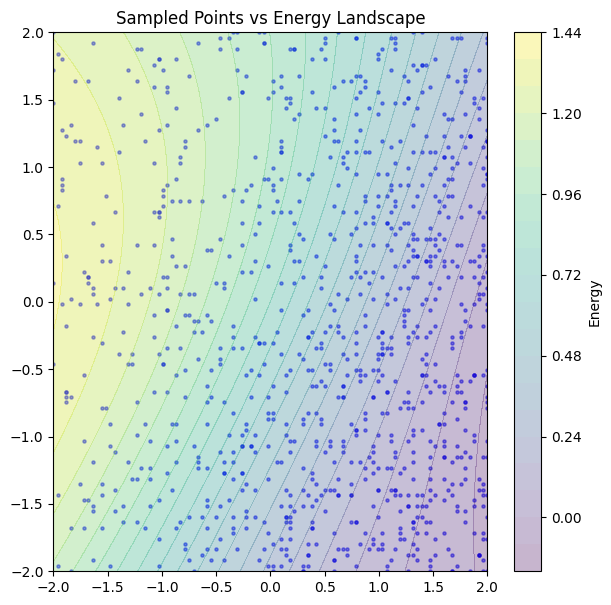

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, s=5, c='blue')
plt.contourf(x_grid, y_grid, energy_grid, levels=20, cmap='viridis', alpha=0.3)
plt.colorbar(label='Energy')
plt.title('Sampled Points vs Energy Landscape')
plt.show()

## Section 4: Contrastive Divergence Intuition

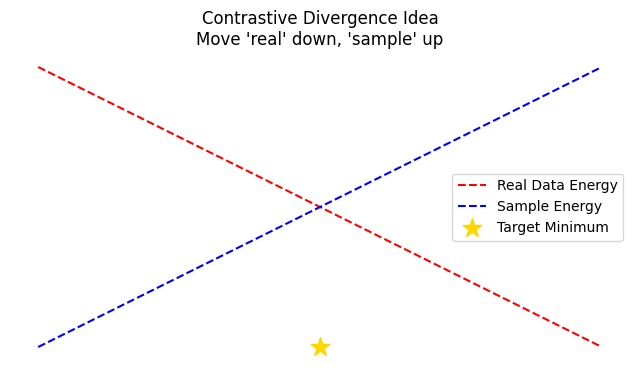

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot([0.2, 0.8], [5, 0], 'r--', label='Real Data Energy')
plt.plot([0.2, 0.8], [0, 5], 'b--', label='Sample Energy')
plt.scatter(0.5, 0, marker='*', s=200, color='gold', label='Target Minimum')
plt.axis('off')
plt.legend()
plt.title("Contrastive Divergence Idea\nMove 'real' down, 'sample' up")
plt.show()

## Section 5: Connection to Project

In [ ]:
print("\nEnergyModel in project's model.py likely has:")
print( "# class EnergyModel(nn.Module):", 
      "\n\tcommon layout:",
      "\n\t- Layer for input -> hidden transformations", 
      "\n\t- Final layer producing energy value", 
      "\n\tLearnable parameters controlling the energy landscape")


EnergyModel in project's model.py likely has:
# class EnergyModel(nn.Module): 
	common layout: 
	- Layer for input -> hidden transformations 
	- Final layer producing energy value 
	Learnable parameters controlling the energy landscape


## Section 6 TalktoEBM implementation

## Section 6 EBM Training

### Explanation of the Code:
Section 1: Energy Basics
 Shows how energy relates to probability density for Gaussians
 Illustrates that lower energy points correspond to higher probabilities

Section 2: Energy Visualization
 Uses a simple neural network with:
 Input layer for 2D coordinates
 Hidden layer (8 neurons) with tanh activation
 Output layer producing scalar energy
 Plots 3D surface and contour maps
 Demonstrates how parameter changes affect the landscape

Section 3: Basic Sampling
 Uses "pseudo-sampling" by:
 Calculate probabilities proportional to exp(-energy)
 Select grid points using weighted selection
 Visualizes sampled points with heatmap overlay showing energy contours

Section 4: Contrastive Divergence Concept
 Simplified visualization showing the core idea of: ↑ Energy on samples and ↓ Energy on real data
 Emphasizes the "push-pull" concept of training EBMs

Section 5: Project Connection
 Shows typical model structure analogous to industry implementations
 Connects visualization examples to real model components